In [1]:
rg_src_id = 900

region_name = "MDIS_10-800" # "TDS" # _ELAISN1
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from astropy.coordinates import SkyCoord
from astropy.table import unique, Table, hstack, join, setdiff
from astropy import units as uu
from astroquery.simbad import Simbad
from astropy.visualization import quantity_support
from astropy.modeling.models import BlackBody

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection, dd_vasca_columns
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, dd_filter2lambda, mag2flux, flux2mag

rg = Region()
rg.load_from_fits(region_fname)
tc_src = rg.get_src_from_id(rg_src_id)
display(tc_src.tt_sources)

nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_src_id,nr_fd_srcs,hr,hr_err,otype,MAIN_ID,OTYPES,Z_VALUE,Distance_distance,Distance_unit,DISTANCE_RESULT,ogrp
,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,arcsec,
int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,bytes4,float32,bytes8
35 .. 55,215.3258439968967,52.596545351520945,0.061777495,-0.073819295,0.27413565,0.076620735,0.8073005,2996,0.15070449,1 .. 2,True,69.76633 .. 78.84212,0.2989939 .. 0.35905793,0.0028636206 .. 0.00013604689,17.501484 .. 8.515412,3.2471413e-13 .. 0.18849026,3.8351877 .. 1.1662406,0.91958094 .. 0.98226017,-18.350433 .. -3.4928458,900,6,1.1639541,0.017203152,WD*,SDSS J142118.18+523547.1,WD*|WD*|blu|WD*|*|Opt|WD?,0.0000500,311.0400,pc,0.5117,WD


(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='MJD', ylabel='Flux [$\\mu$Jy]'>)

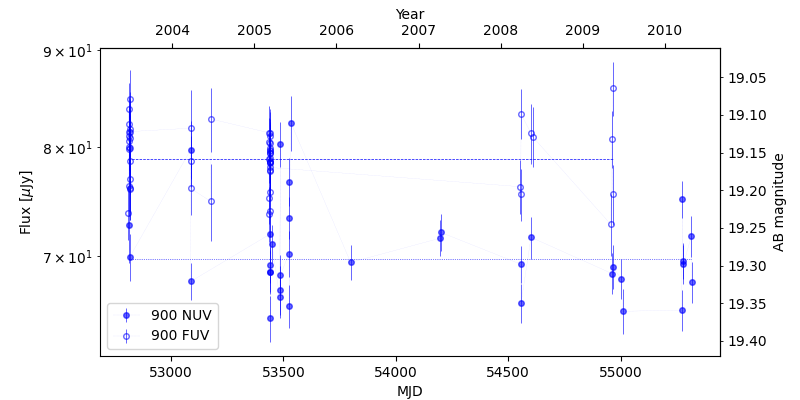

In [2]:
fig_lc_src = plt.figure("Light curve",figsize=(8, 4), clear=True)
vvis.plot_light_curve(rg, rg_src_ids = rg_src_id,fig=fig_lc_src)

/home/buehler/anaconda3/envs/vas/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


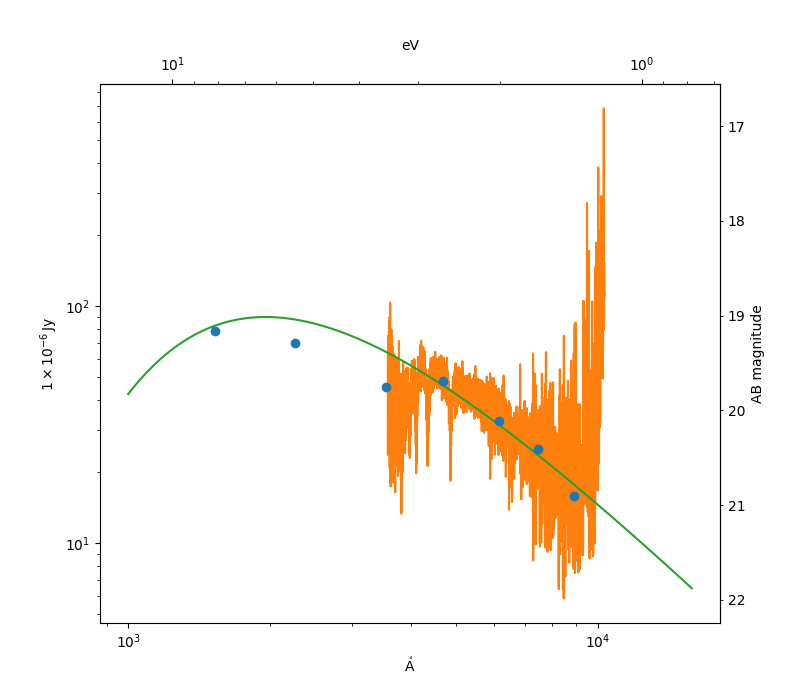

In [55]:
sdss_ftr     = ["u" , "g" , "r"  ,"i" , "z"]
sdss_lambda  = [3546*uu.AA, 4670*uu.AA, 6156*uu.AA ,7472*uu.AA, 8917*uu.AA]
sdss_mag     = [19.758,19.693,20.109,20.405,20.906]
sdss_mag_err = [0.030,0.014,0.022,0.037,0.199] 
sdss_flux, sdss_flux_err  = mag2flux(sdss_mag,sdss_mag_err)

tt_sed = Table()
tt_sed["flux"] = [tc_src.tt_sources["flux"][:,0].quantity[0], tc_src.tt_sources["flux"][:,1].quantity[0]]+list(sdss_flux)
tt_sed["flux_err"] = [tc_src.tt_sources["flux_err"][:,0].quantity[0], tc_src.tt_sources["flux_err"][:,1].quantity[0]]+list(sdss_flux_err)
tt_sed["lambda"] = [dd_filter2lambda["NUV"],dd_filter2lambda["FUV"]]+sdss_lambda 
tt_sed["obs_filter"]= ["NUV","FUV"]+sdss_ftr
tt_sed.sort("lambda")
#display(tt_sed)

bb = BlackBody(temperature=26000*uu.K, scale=2.7e-25)
bb_lambda = np.power(10,np.arange(3, 4.2,0.01)) * uu.AA
bb_flux = bb(bb_lambda).to(uu.Jy/uu.sr)*1*uu.sr

from astropy import constants as cc
from matplotlib.ticker import ScalarFormatter

def AA2ev_np(wave):
    return (cc.h*cc.c/(wave*uu.AA)).to(uu.eV).value
def ev2AA_np(ener):
    return (cc.h*cc.c/(ener*uu.eV)).to(uu.AA).value
def flux2mag_np(flux):
    return flux2mag(flux).data

def mag2flux_np(mag):
    return mag2flux(mag).data

tt = Table.read("spec0.fits", hdu="COADD")
#display(tt)
fig_spec = plt.figure("Spec",figsize=(8, 7), clear=True)
spec_lam = np.power(10,tt["loglam"]) * uu.AA
spec_flux = tt["flux"] * 1e-17 * uu.erg/(uu.cm**2 * uu.s *uu.AA)
s2n = tt["flux"]*np.sqrt(tt["ivar"])
sel = s2n>1
c_Aps = cc.c.to(uu.AA/uu.s)
sed_flux = (spec_flux* spec_lam ** 2 / c_Aps).to(uu.Jy)
    
with quantity_support():
    fig_src = plt.figure("SED",figsize=(8, 7), clear=True)
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(tt_sed["lambda"].quantity,tt_sed["flux"].quantity,yerr= tt_sed["flux_err"].quantity , fmt="o")
    plt.plot(spec_lam[sel],sed_flux[sel])
    plt.plot(bb_lambda,bb_flux)

    ax = plt.gca()
    secax = ax.secondary_xaxis("top", functions=(AA2ev_np, ev2AA_np))
    secax.set_xlabel("eV")

    secay = ax.secondary_yaxis("right", functions=(flux2mag_np, mag2flux_np))

    # Avoid scientific notation for magnitudes
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    secay.yaxis.set_minor_formatter(formatter)

    secay.set_ylabel("AB magnitude")
    plt.show()

In [9]:
from astroquery.sdss import SDSS
pos = SkyCoord(tc_src.tt_sources["ra"].quantity,tc_src.tt_sources["dec"].quantity,frame='icrs')
xid = SDSS.query_region(pos, radius='1 arcsec', spectro=True)
display(xid)
ll_sp = SDSS.get_spectra(matches=xid)
ll_sp[0].writeto("spec0.fits", overwrite=True)
ll_sp[1].writeto("spec1.fits", overwrite=True)

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,str7
215.325821282961,52.596415175769,1237661385994928169,3705,301,1,114,-0.0003392899,7027,56448,15,7911702876732545024,v5_13_2
215.325821282961,52.596415175769,1237661385994928169,3705,301,1,114,-0.0001586706,1326,52764,250,1493012042322307072,26


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7efe3935c130>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe3935e320>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe39197f40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe391c4910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe391c6b90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe39184e50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe39186c80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe39224f40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe392271c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7efe39255480>]

|Filter|`sedpy` Name|$\lambda_\textrm{eff}$|$\Delta\lambda_\textrm{eff}$|Comments|
|:----:|:----------:|---------------------:|---------------------------:|:-------|
|$u$|[`sdss_u0`](filters/sdss_u0.par)|354.6 nm|45.72 nm||
|$g$|[`sdss_g0`](filters/sdss_g0.par)|467.0 nm|92.79 nm||
|$r$|[`sdss_r0`](filters/sdss_r0.par)|615.6 nm|81.28 nm||
|$i$|[`sdss_i0`](filters/sdss_i0.par)|747.2 nm|89.08 nm||
|$z$|[`sdss_z0`](filters/sdss_z0.par)|891.7 nm|118.3 nm||

https://github.com/bd-j/sedpy/blob/main/sedpy/data/filters/README.md

u (AB) 19.758 [0.030] C 2015ApJS..219...12A\
g (AB) 19.693 [0.014] \
r (AB) 20.109 [0.022] \
i (AB) 20.405 [0.037] \
z (AB) 20.906 [0.199] 